In [1]:
include("../path.jl")
include("../ToolBox/ToolBox.jl")
using .ToolBox
using .Geometry
using Images
using Statistics
using BenchmarkTools

In [2]:
using Base.Cartesian

# credit https://github.com/aamini/FastConv.jl
# direct version (do not check if threshold is satisfied)
@generated function fastconv(E::Array{T,N}, k::Array{T,N}) where {T,N}
    quote

        retsize = [size(E)...] + [size(k)...] .- 1
        retsize = tuple(retsize...)
        ret = zeros(T, retsize)

        convn!(ret,E,k)
        return ret

    end
end

# credit https://github.com/aamini/FastConv.jl
# in place helper operation to speedup memory allocations
@generated function convn!(out::Array{T}, E::Array{T,N}, k::Array{T,N}) where {T,N}
    quote
        @inbounds begin
            @nloops $N x E begin
                @nloops $N i k begin
                    (@nref $N out d->(x_d + i_d - 1)) += (@nref $N E x) * (@nref $N k i)
                end
            end
        end
        return out
    end
end

convn! (generic function with 1 method)

In [15]:
# TODO:
# - skift amplitude til intensity
function complex_coherence_fast(master, slave, flat, kernel, view)
    # Define relevant image signals
    signal_1 = master_data .* conj.(slave_data) .* flat
    signal_2 = abs2.(master_data)
    signal_3 = abs2.(slave_data)
    kernel_1 = convert.(eltype(signal_1),kernel)
    kernel_2 = convert.(eltype(signal_2),kernel)
    kernel_3 = convert.(eltype(signal_3),kernel)
    
    # Compute real and imaginary parts seperately
    interferogram =  fastconv(signal_1, kernel_1)
    master_amplitude = fastconv(signal_2, kernel_2)
    slave_amplitude = fastconv(signal_3, kernel_3)

    # Compute the complex coherence
    complex_coherence = interferogram ./ (sqrt.(master_amplitude .* slave_amplitude));
    
    # Cut away padded areas
    no_padd = (size(kernel, 1):size(master, 1)-size(kernel, 1)+1, size(kernel, 2):size(master, 2)-size(kernel, 2)+1)
    complex_coherence = complex_coherence[no_padd...]
    master_amplitude = master_amplitude[no_padd...]
    slave_amplitude = slave_amplitude[no_padd...]

    # Pixel positions in line, sample
    lines = (size(kernel, 2)/2:1:size(master_data,2) - size(kernel, 2)/2) .+ view[2].start
    samples = (size(kernel, 1)/2:1:size(master_data,1) - size(kernel, 1)/2) .+ view[1].start

    return complex_coherence, master_amplitude, slave_amplitude, lines, samples
end

complex_coherence_fast (generic function with 1 method)

In [4]:
function complex_coherence_slow(master, slave, flattening_phase, kernel)
    # get the size of the coherence array
    number_of_rows = size(master_data)[1] - size(kernel)[1] + 1
    number_of_cols = size(master_data)[2] - size(kernel)[2] + 1

    # placeholder arrays
    master_abs_sq = Array{Complex{Float64}, 2}(undef, number_of_rows, number_of_cols)
    slave_abs_sq = Array{Complex{Float64}, 2}(undef, number_of_rows, number_of_cols)
    complex_coherence = Array{Complex{Float64}, 2}(undef, number_of_rows, number_of_cols)

    for i in 1:number_of_rows
        for j in 1:number_of_cols
            i_range = i:(i + size(kernel)[1] - 1)
            j_range = j:(j + size(kernel)[2] - 1)
            nominator = sum(kernel .* master_data[i_range, j_range] .* conj.(slave_data[i_range, j_range]) .* flat[i_range, j_range])
            master_abs_sq[i, j] = sqrt(sum(abs2.(kernel .* master_data[i_range, j_range])))
            slave_abs_sq[i, j] = sqrt(sum(abs2.(kernel .* slave_data[i_range, j_range])))
            complex_coherence[i, j] = nominator / (master_abs_sq[i, j] * slave_abs_sq[i, j])
        end
    end
    return complex_coherence
end

complex_coherence_slow (generic function with 1 method)

In [2]:
master_view = [100:1500,3000:5500]

2-element Array{UnitRange{Int64},1}:
 100:1500 
 3000:5500

In [3]:
# load meta and pod
master_meta = Load.slc_meta(master_meta_path);
master_precise_orbit = Load.precise_orbit(master_pod_path,master_meta["t_0"]);
slave_meta = Load.slc_meta(slave_meta_path);
slave_precise_orbit = Load.precise_orbit(slave_pod_path,slave_meta["t_0"]);

In [4]:
meta = (master_meta,slave_meta)
precise_orbit = (master_precise_orbit,slave_precise_orbit);

In [5]:
master_data = Load.slc_data(master_data_path, master_view);

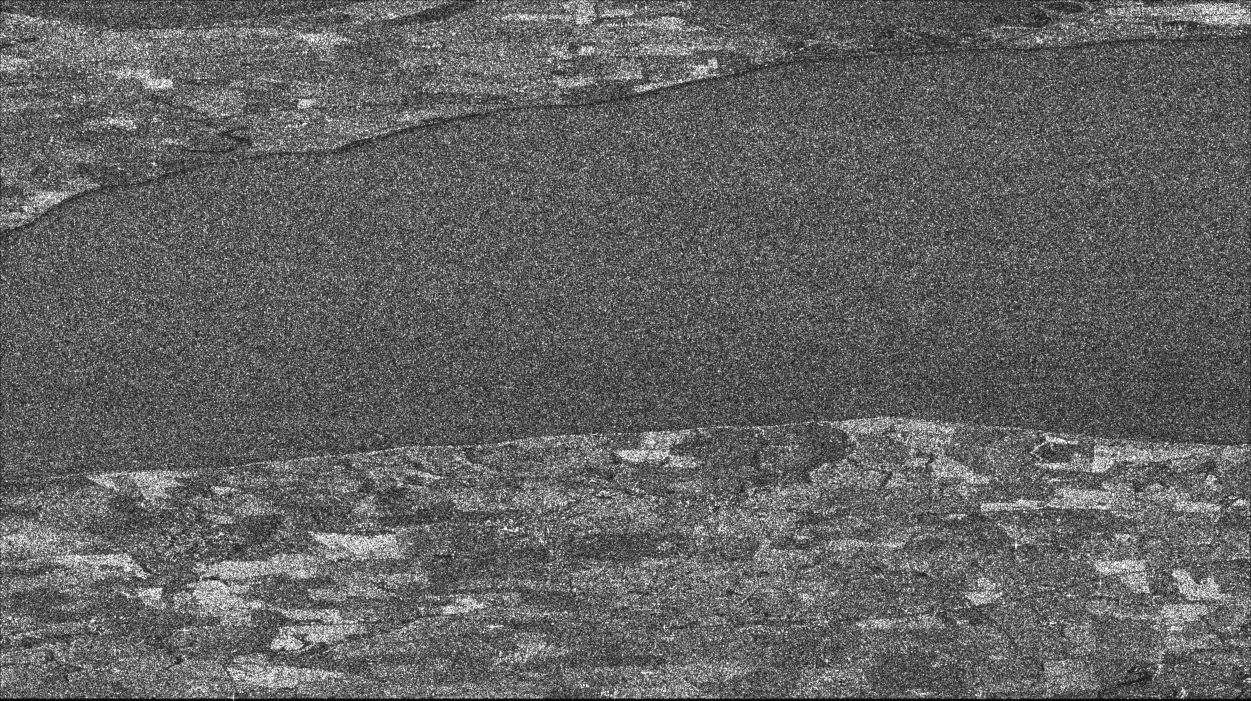

In [6]:
SlcUtil.show_img(master_data)

In [7]:
# load DEM
footprint = SlcUtil.footprint(master_meta, master_view)
latlon_window = ((minimum(footprint[1]), maximum(footprint[1])), (minimum(footprint[2]), maximum(footprint[2])))
dem = Load.dem(dem_path, latlon_window; nan_fill= 0, padding=[90,90]);

In [8]:

slave_data, flat, lut = coregister_slave(master_view, slave_data_path, meta, precise_orbit, dem);

In [9]:
kernel = ones(4, 13)

4×13 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [10]:
complex_coherence, master_amplitude, slave_amplitude, lines, samples = SlcUtil.complex_coherence(master_data, slave_data, flat, kernel, master_view);

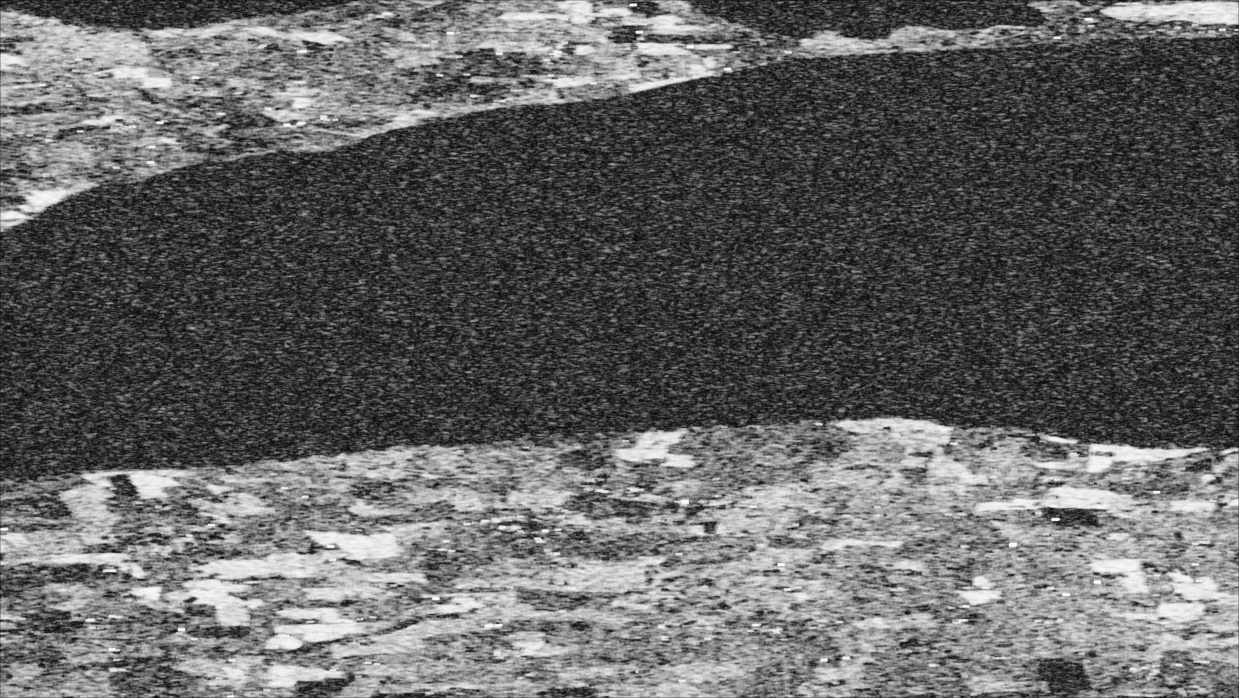

In [11]:
Gray.(abs.(complex_coherence))

In [12]:
println(mean(mean(abs.(complex_coherence))))
println(maximum(maximum(abs.(complex_coherence))))
println(minimum(minimum(abs.(complex_coherence))))

0.39379497827907656
0.994626952447752
5.405610775988225e-5


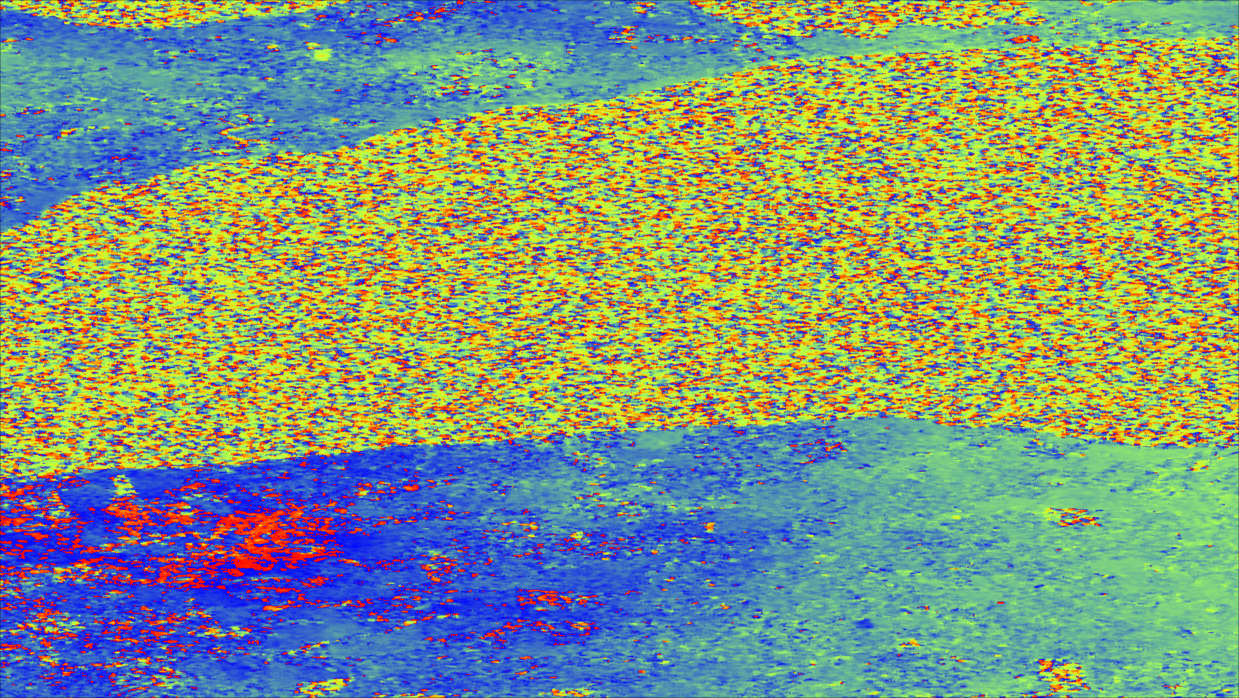

In [13]:
SlcUtil.plot_phase(complex_coherence)

In [22]:
SlcUtil._phase_colorbar()

 -π                 -π/2                 0                 π/2                 π


In [23]:
#The line sample output from the coherence function
lines, samples

(3006.5:1.0:5494.5, 102.0:1.0:1499.0)

### Unbiased coherence

In [45]:
using ImageFiltering
using Statistics
using Images

In [83]:
ker = Kernel.gaussian((std(abs.(complex_coherence)), std(abs.(complex_coherence))), (3,3))
ker = reshape(ker[:], (3,3))

333×333 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [84]:
unbiased = fastconv(abs.(complex_coherence), ker);

InterruptException: InterruptException:

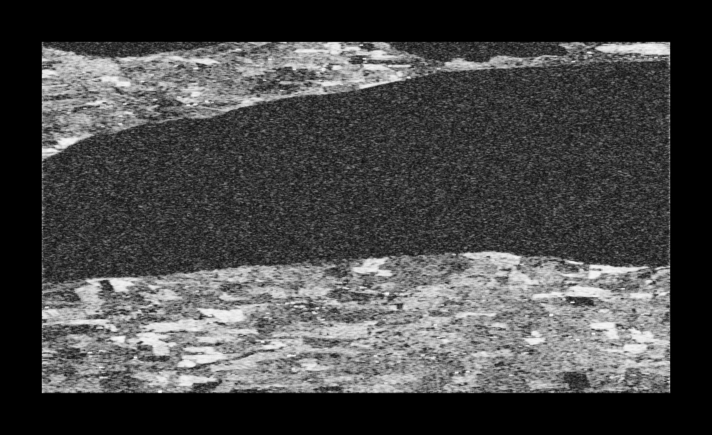

In [85]:
Gray.(unbiased)

In [86]:
println(mean(mean(abs.(unbiased))))
println(maximum(maximum(abs.(unbiased))))
println(minimum(minimum(abs.(unbiased))))

0.2818100312625547
0.9995785881524065
0.0
